Loading in the data

In [ ]:
import pandas as pd

# Load the Excel file and read the first sheet into a DataFrame
file_path = "Vareposter Alfotech.xlsx"
sales_df = pd.read_excel(file_path, header=0)

# Remap Montageforbrug → Salg in-place
sales_df['Posttype'] = sales_df['Posttype'].replace({'Montageforbrug': 'Salg'})
sales_df.head()

# Data analysis

#### Supplier - Dicsa
Creating Dicsa dataset isolating the supplier number

In [3]:
dicsa_df = sales_df[sales_df['Leverandørnr.'] == 'ES976464']

In [14]:
# Keep only the relevant columns
relevant_columns = [
    'Bogføringsdato',
    'Posttype',
    'Varenr.',
    'Beskrivelse',
    'Antal',
    'Salgsbeløb (faktisk)',
    'Kostbeløb (faktisk)',
    'Leverandørnr.'
]
dicsa_df = dicsa_df[relevant_columns]

# Display the first few rows to confirm
display(dicsa_df.head())

KeyError: "['Beskrivelse'] not in index"

In [5]:
# Filter for 'Salg' og 'Køb posttype
dicsa_sales = dicsa_df[dicsa_df['Posttype'] == 'Salg']
dicsa_purchase = dicsa_df[dicsa_df['Posttype'] == 'Køb']

# Calculate unit cost for 'Salg'
dicsa_unitcost_sales = dicsa_sales['Kostbeløb (faktisk)'] / dicsa_sales['Antal']
# Calculate unit cost for 'Køb'
dicsa_unitcost_purchase = dicsa_purchase['Kostbeløb (faktisk)'] / dicsa_purchase['Antal']
dicsa_unitcost = dicsa_df['Kostbeløb (faktisk)'] / dicsa_df['Antal']

# Calculate and print the average unit cost
average_unitcost_sales = dicsa_unitcost_sales.mean()
average_unitcost_purchase = dicsa_unitcost_purchase.mean()
average_unitcost = dicsa_unitcost.mean()
print("Average unit cost combined", average_unitcost)
print("Average unit cost for 'Salg':", average_unitcost_sales)
print("Average unit cost for 'Køb':", average_unitcost_purchase)


Average unit cost combined 60.40193796141841
Average unit cost for 'Salg': 57.67963945368014
Average unit cost for 'Køb': 74.80840371105901


In [6]:
# Sales price per unit
dicsa_sales_price_per_unit = dicsa_sales['Salgsbeløb (faktisk)'] / dicsa_sales['Antal']

average_sales_price_per_unit = dicsa_sales_price_per_unit.mean()
print("Average sales price per unit:", abs(average_sales_price_per_unit))

Average sales price per unit: 53.321540430132735


#### Descriptive insights

In [12]:
# Total sales and purchases per product
sales = dicsa_df[dicsa_df['Posttype'] == 'Salg'].groupby('Varenr.').agg(
    total_units_sold=('Antal', 'sum'),
    total_sales_value=('Salgsbeløb (faktisk)', 'sum'),
    transactions=('Antal', 'count')
)
purchases = dicsa_df[dicsa_df['Posttype'] == 'Køb'].groupby('Varenr.').agg(
    total_units_purchased=('Antal', 'sum'),
    total_purchase_cost=('Kostbeløb (faktisk)', 'sum'),
    purchase_transactions=('Antal', 'count')
)
display(sales.head())
display(purchases.head())

,total_units_sold,total_sales_value,transactions
Varenr.,,,
0100600060,-20.0,340.0,1
0100600080,-150.0,2675.4,4
0100600100,-30.0,660.0,1
0100610010,-4.0,637.2,1
0100629060,-2.0,288.0,1


,total_units_purchased,total_purchase_cost,purchase_transactions
Varenr.,,,
0100600080,120.0,472.47,1
0100629060,2.0,80.38,1
0100629130,4.0,602.33,1
0100630008,11.0,343.55,2
0100630022,4.0,358.49,1


In [ ]:
# Calculate average inventory as average of purchased units (simple proxy)
turnover = pd.merge(sales, purchases, left_index=True, right_index=True, how='outer').fillna(0)
turnover['turnover_rate'] = turnover['total_units_sold'] / (turnover['total_units_purchased'] / turnover['purchase_transactions'])
display(turnover.sort_values('turnover_rate', ascending=True).head())

,total_units_sold,total_sales_value,transactions,total_units_purchased,total_purchase_cost,purchase_transactions,turnover_rate
Varenr.,,,,,,,
0492210014,-654.0,0.00,48.0,640.0,10304.75,16.0,-16.350000
0463902506,-457.0,13465.31,83.0,450.0,26589.24,16.0,-16.248889
0463903806,-223.0,6959.40,45.0,220.0,14967.34,12.0,-12.163636
04911104120A,-1376.0,9520.00,449.0,1025.0,31722.48,9.0,-12.081951
04911103120A,-321.0,4046.00,92.0,300.0,11480.24,11.0,-11.770000


In [ ]:
# Gross margin per product
dicsa_df['gross_margin'] = dicsa_df['Salgsbeløb (faktisk)'] - dicsa_df['Kostbeløb (faktisk)']
margin = dicsa_df[dicsa_df['Posttype'] == 'Salg'].groupby('Varenr.').agg(
    total_sales=('Salgsbeløb (faktisk)', 'sum'),
    total_cost=('Kostbeløb (faktisk)', 'sum'),
    total_margin=('gross_margin', 'sum')
)
margin['margin_pct'] = margin['total_margin'] / margin['total_sales']
display(margin.sort_values('margin_pct', ascending=True).head())

,total_sales,total_cost,total_margin,margin_pct
Varenr.,,,,
0100630012,0.00,8.45,-8.45,-inf
0472472025,420.00,-43.04,463.04,1.102476
04911100120C,392.08,-49.00,441.08,1.124974
0472412012,3060.00,-428.55,3488.55,1.140049
0492339101,1442.00,-229.85,1671.85,1.159397


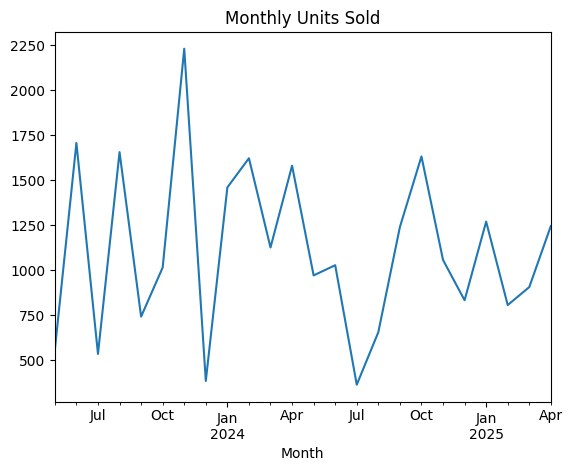

In [10]:
import matplotlib.pyplot as plt
# Monthly sales trend
dicsa_df['Bogføringsdato'] = pd.to_datetime(dicsa_df['Bogføringsdato'])
dicsa_df['Month'] = dicsa_df['Bogføringsdato'].dt.to_period('M')
monthly_sales = dicsa_df[dicsa_df['Posttype'] == 'Salg'].groupby('Month')['Antal'].sum().abs()
monthly_sales.plot(title='Monthly Units Sold')
plt.show()

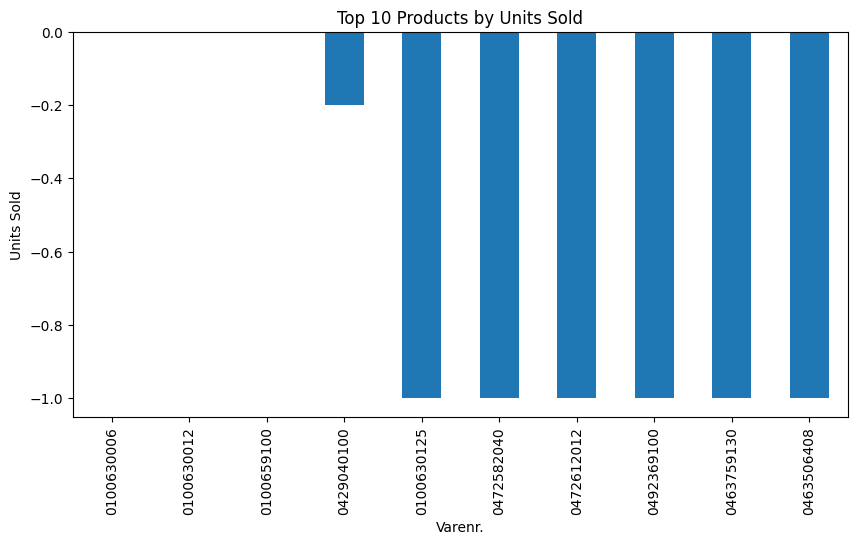

In [13]:
import matplotlib.pyplot as plt

top10_sold = sales.sort_values('total_units_sold', ascending=False).head(10)
top10_sold['total_units_sold'].plot(kind='bar', figsize=(10,5), title='Top 10 Products by Units Sold')
plt.ylabel('Units Sold')
plt.xlabel('Varenr.')
plt.show()